In [170]:
import tensorflow as tf
from glob import glob
import os
import random
import numpy as np
import cv2
from skimage.io import imread, imshow
from PIL import Image
from matplotlib import pyplot as plt
import imageio
from tqdm import tqdm

In [171]:
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3

Load data

In [172]:
data_path = 'DatasetRetina' 

train_x = sorted(glob(os.path.join(data_path, "training", "images", "*.tif")))
train_y = sorted(glob(os.path.join(data_path, "training", "mask", "*.gif")))

test_x = sorted(glob(os.path.join(data_path, "test", "images", "*.tif")))
test_y = sorted(glob(os.path.join(data_path, "test", "mask", "*.gif")))

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Test: {len(test_x)} - {len(test_y)}")




Train: 20 - 20
Test: 20 - 20


In [173]:
if not os.path.exists("new_data/train/image"):
    os.makedirs("new_data/train/image")
if not os.path.exists("new_data/train/mask"):    
    os.makedirs("new_data/train/mask")
if not os.path.exists("new_data/test/image"):
    os.makedirs("new_data/test/image")
if not os.path.exists("new_data/test/mask"):
    os.makedirs("new_data/test/mask")



New JPEG Training data

In [174]:
for idx, (x, y) in tqdm(enumerate(zip(train_x, train_y)), total=len(test_x)):
    x = x.replace('\\', '/')
    y = y.replace('\\', '/')
    name = x.split("/")[-1].split(".")[0]
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    y = imageio.mimread(y)[0]
    X = [x]
    Y = [y]
    for i, m in zip(X, Y):
        i = cv2.resize(i, (IMG_WIDTH, IMG_HEIGHT))
        m = cv2.resize(m, (IMG_WIDTH, IMG_HEIGHT))
        tmp_image_name = f"{name}.jpg"
        tmp_mask_name = f"{name}.jpg"
        image_path = os.path.join("new_data/train/", "image", tmp_image_name)
        mask_path = os.path.join("new_data/train/", "mask", tmp_mask_name)
        cv2.imwrite(image_path, i)
        cv2.imwrite(mask_path, m)

100%|██████████| 20/20 [00:03<00:00,  5.94it/s]


New JPEG Testing data

In [175]:
for idx, (x, y) in tqdm(enumerate(zip(test_x, test_y)), total=len(train_x)):
    x = x.replace('\\', '/')
    y = y.replace('\\', '/')
    name = x.split("/")[-1].split(".")[0]
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    y = imageio.mimread(y)[0]
    X = [x]
    Y = [y]
    for i, m in zip(X, Y):
        i = cv2.resize(i, (IMG_WIDTH, IMG_HEIGHT))
        m = cv2.resize(m, (IMG_WIDTH, IMG_HEIGHT))
        tmp_image_name = f"{name}.jpg"
        tmp_mask_name = f"{name}.jpg"
        image_path = os.path.join("new_data/test/", "image", tmp_image_name)
        mask_path = os.path.join("new_data/test/", "mask", tmp_mask_name)
        cv2.imwrite(image_path, i)
        cv2.imwrite(mask_path, m)

100%|██████████| 20/20 [00:03<00:00,  6.35it/s]


Filling arrays of X_train and y_train

In [176]:
TRAIN_PATH = 'new_data/train/'

train_image = os.listdir(TRAIN_PATH + "image/")
train_mask = os.listdir(TRAIN_PATH + 'mask/')

X_train = []
y_train = []

for n, id_ in enumerate(train_image):   
    path = TRAIN_PATH + 'image/' + id_
    img = cv2.imread(path)
    img = Image.fromarray(img, 'RGB')
    X_train.append(np.array(img))

for n, id_ in enumerate(train_mask):   
    path = TRAIN_PATH + 'mask/' + id_
    img = cv2.imread(path, 0)
    img = Image.fromarray(img)
    y_train.append(np.array(img))


In [177]:
TEST_PATH = 'new_data/test/'

test_image = os.listdir(TEST_PATH + "image/") 
test_mask = os.listdir(TEST_PATH + "mask/")

X_test = []
y_test = []
for n, id_ in enumerate(train_image):   
    path = TRAIN_PATH + 'image/' + id_
    img = cv2.imread(path)
    img = Image.fromarray(img, 'RGB')
    X_test.append(np.array(img))

for n, id_ in enumerate(test_mask):   
    path = TEST_PATH + 'mask/' + id_
    img = cv2.imread(path, 0)
    img = Image.fromarray(img)
    y_test.append(np.array(img))

In [194]:
temp_path = TRAIN_PATH + 'image/'
train_ids = next(os.walk(temp_path))[2]
train_ids[0]

'21_training.jpg'

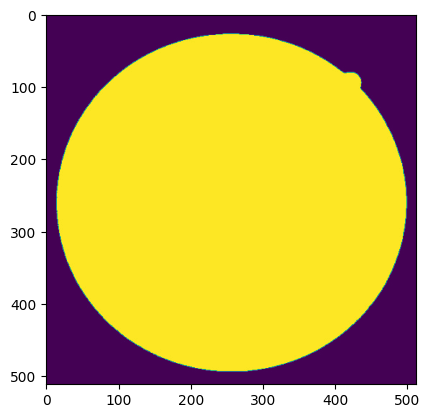

In [178]:
plt.imshow(y_test[0])

In [179]:
y_train[0].shape

(512, 512)

Build model

In [180]:


#Build the model
inp = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

#Contraction path
conv1 = tf.keras.layers.Conv2D(64, (3, 3), 
                            activation='relu', 
                            kernel_initializer='he_normal', 
                            padding='same'
                            )(inp)
conv1 = tf.keras.layers.Conv2D(64, (3, 3), 
                            activation='relu', 
                            kernel_initializer='he_normal', 
                            padding='same'
                            )(conv1)
pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv1)

conv2 = tf.keras.layers.Conv2D(128, (3, 3), 
                               activation='relu', 
                               kernel_initializer='he_normal', 
                               padding='same'
                               )(pool1)
conv2 = tf.keras.layers.Conv2D(128, (3, 3), 
                               activation='relu', 
                               kernel_initializer='he_normal', 
                               padding='same'
                               )(conv2)
pool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv2)
 
conv3 = tf.keras.layers.Conv2D(256, (3, 3), 
                            activation='relu', 
                            kernel_initializer='he_normal', 
                            padding='same'
                            )(pool2)
conv3 = tf.keras.layers.Conv2D(256, (3, 3), 
                               activation='relu', 
                               kernel_initializer='he_normal', 
                               padding='same'
                               )(conv3)
pool3 = tf.keras.layers.MaxPooling2D((2, 2))(conv3)
 
conv4 = tf.keras.layers.Conv2D(512, (3, 3), 
                            activation='relu', 
                            kernel_initializer='he_normal', 
                            padding='same'
                            )(pool3)
conv4 = tf.keras.layers.Conv2D(512, (3, 3), 
                            activation='relu', 
                            kernel_initializer='he_normal', 
                            padding='same'
                            )(conv4)
drop4 = tf.keras.layers.Dropout(0.2)(conv4)
pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)
 
conv5 = tf.keras.layers.Conv2D(1024, (3, 3), 
                            activation='relu', 
                            kernel_initializer='he_normal', 
                            padding='same'
                            )(pool4)
conv5 = tf.keras.layers.Conv2D(1024, (3, 3), 
                            activation='relu', 
                            kernel_initializer='he_normal', 
                            padding='same'
                            )(conv5)
drop5 = tf.keras.layers.Dropout(0.3)(conv5)


#Expansive path 
up6 = tf.keras.layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(drop5)
merge6 = tf.keras.layers.concatenate([up6, drop4])
conv6 = tf.keras.layers.Conv2D(512, (3, 3), 
                            activation='relu', 
                            kernel_initializer='he_normal', 
                            padding='same'
                            )(merge6)
conv6 = tf.keras.layers.Conv2D(512, (3, 3), 
                               activation='relu', 
                               kernel_initializer='he_normal', 
                               padding='same'
                               )(conv6)
 
up7 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
merge7 = tf.keras.layers.concatenate([up7, conv3])
conv7 = tf.keras.layers.Conv2D(256, (3, 3), 
                            activation='relu', 
                            kernel_initializer='he_normal', 
                            padding='same'
                            )(merge7)
conv7 = tf.keras.layers.Conv2D(256, (3, 3), 
                               activation='relu', 
                               kernel_initializer='he_normal', 
                               padding='same'
                               )(conv7)
 
up8 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
merge8 = tf.keras.layers.concatenate([up8, conv2])
conv8 = tf.keras.layers.Conv2D(128, (3, 3), 
                            activation='relu', 
                            kernel_initializer='he_normal', 
                            padding='same'
                            )(merge8)
conv8 = tf.keras.layers.Conv2D(128, (3, 3), 
                               activation='relu', 
                               kernel_initializer='he_normal', 
                               padding='same'
                               )(conv8)
 
up9 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
merge9 = tf.keras.layers.concatenate([up9, conv1], axis=3)
conv9 = tf.keras.layers.Conv2D(64, (3, 3), 
                            activation='relu', 
                            kernel_initializer='he_normal', 
                            padding='same'
                            )(merge9)
conv9 = tf.keras.layers.Conv2D(64, (3, 3), 
                            activation='relu', 
                            kernel_initializer='he_normal', 
                            padding='same'
                            )(conv9)
conv9 = tf.keras.layers.Conv2D(2, (3, 3), 
                            activation='relu', 
                            kernel_initializer='he_normal', 
                            padding='same'
                            )(conv9)

out = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(conv9)
 
model = tf.keras.Model(inputs=[inp], outputs=[out])
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_140 (Conv2D)            (None, 512, 512, 64  1792        ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_141 (Conv2D)            (None, 512, 512, 64  36928       ['conv2d_140[0][0]']             
                                )                                                           

Training the model

In [181]:
# checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', 
#                                                   verbose=1, 
#                                                   save_best_only=True)
# callbacks = [
#         tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
#         tf.keras.callbacks.TensorBoard(log_dir='logs')]

# results = model.fit(X_train, y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)